<table class="ee-notebook-buttons" align="left">
    <td><a target="_blank"  href="https://github.com/NINAnor/urban-treeDetection"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" style="filter: invert(100%)"/> View source on GitHub</a></td>
    <td><a target="_blank"  href="https://drive.google.com/drive/folders/1mEQBfa-tVViVWFt27XzUP4Wr19u1iuZm"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a></td>
</table>

# Urban Tree Detection | Extrapolating Ecosystem Service Values

**Author:** Willeke A'Campo

**Description:** Script to clean the output i-Tree Eco dataset and extrapolate the Ecosystem Service Values to all trees in the municipality. The regression is trained on the in situ tree dataset from the municipality or if not availabe on Oslo's tree in situ tree data. 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import geopandas as gpd
from scipy import stats
#from splot.esda import moran_scatterplot, plot_moran

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
# import  py-packages 
import os
import logging 

# import local packages
from src import (MUNICIPALITY, TOOL_PATH, DATA_PATH, INTERIM_PATH)
from src import logger

In [5]:
print(INTERIM_PATH)

C:\Data\offline_data\trekroner\data\oslo\interim


In [6]:
# configure seaborn plot
sns.set_theme(context="notebook",   # paper, notebook, talk, and poster
              style="darkgrid",     # darkgrid, whitegrid, dark, white, and ticks
              palette="dark",       # deep, muted, bright, pastel, dark, and colorblind
              font="sans-serif",    # font family: serif, sans-serif, cursive, fantasy, and monospace
              font_scale=1,         # 1 = default font size (12pt)
              color_codes=True,     # False = don't color code from current palette
              rc=None               # dict for additional settings (e.g. axes.labelsize=15)
              )

In [7]:
# configure logger
logger.setup_logger(logfile=False)
logging.info(f'Start preparing the tree database of {MUNICIPALITY}.')

# print global project variables
print(f'data_path: {DATA_PATH}')
print(f'interim_data_path: {INTERIM_PATH}')

2023.05.26T18:59:03Z [DEBUG] src.utils.logger: Logging initialized
2023.05.26T18:59:03Z [INFO] root: Start preparing the tree database of oslo.
data_path: C:\Data\offline_data\trekroner\data
interim_data_path: C:\Data\offline_data\trekroner\data\oslo\interim


### Import Reference Data Oslo

In [8]:
# load the Excel file into a lookup dictionairy 
excel_path = os.path.join(INTERIM_PATH, "oslo_reference_data.xlsx")
print(excel_path)

workbook = pd.ExcelFile(excel_path)
sheet_names = workbook.sheet_names
print(f"workbook sheet names: {sheet_names}")

# import Oslo's reference dataset
df_raw = pd.read_excel(excel_path, sheet_name="oslo_reference_data")

# import metadata
df_metadata = pd.read_excel(excel_path, sheet_name="metadata")
df_metadata = df_metadata[['urban-treeDetection_colnames', 'python_colnames', 'dtype']]

# import genus list 
df_genus = pd.read_excel(excel_path, sheet_name="unique_genus")
genus_bins = df_genus['genus'].tolist()

print("Raw data information: Oslo Reference Data")
display(df_raw.head())
print("Rows in dataframe: ", len(df_raw))
print(f"\nunique genus: {genus_bins}")
print("\nMetadata information: ")
display(df_metadata.head())

C:\Data\offline_data\trekroner\data\oslo\interim\oslo_reference_data.xlsx
workbook sheet names: ['test_extrapolation_data', 'oslo_reference_data', 'unique_taxon', 'unique_genus', 'metadata']
Raw data information: Oslo Reference Data


,tree_id,crown_id,pollution_zone,crown_area_m2,tree_height_m,taxon_name,dbh_cm,crown_area_origin,total_tree_height_origin,taxon_origin,...,co_seq_kg,runoff_m3,polution_no2_g,polution_so2_g,polution_pm25_g,polution_co_g,polution_o3_g,totben_cap_nok,wgs84_lon,wgs84_lat
0,14689,4977.0,1.0,87.319154,15.081635,NaN,37.386005,"ALS, intersecting BYM, LiDAR",measured from DSM-DTM 3x3 rook's nb,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.657796,59.969877
1,14690,4978.0,1.0,105.000534,4.408203,NaN,13.635651,"ALS, intersecting BYM, LiDAR",measured from DSM-DTM point value,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.657938,59.969788
2,14691,NaN,1.0,NaN,1.832062,NaN,6.637312,NaN,measured from DSM-DTM 3x3 rook's nb,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.658075,59.969748
3,14692,NaN,1.0,NaN,3.208923,NaN,10.509838,NaN,measured from DSM-DTM 3x3 rook's nb,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.658295,59.969679
4,14693,17997.0,1.0,9.230826,0.679657,NaN,2.943466,"ALS, intersecting BYM, Thiessen",measured from DSM-DTM 3x3 rook's nb,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.657486,59.970029


Rows in dataframe:  29928

unique genus: ['Fraxinus', 'Acer', 'Ulmus', 'Betula', 'Picea', 'Pinus', 'Fagus', 'Tilia', 'Thuja', 'Salix', 'Populus', 'Alnus', 'Quercus', 'Malus', 'Prunus', 'Aesculus', 'Larix', 'Laburnum', 'Sorbus', 'Photinia', 'Cercidiphyllum', 'Pseudotsuga', 'Carpinus', 'Cupressocyparis', 'Juglans', 'Magnolia', 'Pyrus', 'Ginkgo', 'Crataegus', 'Syringa', 'Abies', 'Tsuga', 'Corylus', 'Pterocarya', 'Castanea', 'Metasequoia', 'Taxus', 'Liriodendron', 'Phellodendron', 'Ailanthus', 'Robinia', 'Davidia', 'Platanus', 'Juniperus']

Metadata information: 


,urban-treeDetection_colnames,python_colnames,dtype
0,tree_id,tree_id,int
1,crown_id,crown_id,int
2,pollution_zone,pollution_zone,int
3,crown_area_m2,crown_area,float64
4,tree_height_m,tree_height,float64


### Clean dataset
- remove rows with missing values
- remove rows with negative values (not done)

In [9]:
# drop rows with missing values
df = df_raw.dropna()
# drop rows with missing values
df = df.dropna()
display(df.head())

,tree_id,crown_id,pollution_zone,crown_area_m2,tree_height_m,taxon_name,dbh_cm,crown_area_origin,total_tree_height_origin,taxon_origin,...,co_seq_kg,runoff_m3,polution_no2_g,polution_so2_g,polution_pm25_g,polution_co_g,polution_o3_g,totben_cap_nok,wgs84_lon,wgs84_lat
73,14640,18010.0,1.0,7.644361,6.354904,Fraxinus,18.404785,"ALS, intersecting BYM, Thiessen",measured from DSM-DTM 3x3 rook's nb,1.0,...,3.0,0.1,8.2,0.6,0.9,0.7,18.3,671.685832,10.641744,59.961983
75,14644,4988.0,1.0,168.883335,15.855560,Acer,38.952046,"ALS, intersecting BYM, LiDAR",measured from DSM-DTM 3x3 rook's nb,1.0,...,15.1,3.7,234.5,17.3,24.5,21.2,525.4,15053.486424,10.642142,59.962042
76,14645,18012.0,1.0,126.770866,18.937744,Fraxinus,45.059931,"ALS, intersecting BYM, Thiessen",measured from DSM-DTM 3x3 rook's nb,1.0,...,10.6,1.6,99.3,7.3,10.4,9.0,222.4,7341.197038,10.642501,59.962011
78,14647,4987.0,1.0,221.395426,16.470413,Fraxinus,40.186395,"ALS, intersecting BYM, LiDAR",measured from DSM-DTM point value,1.0,...,12.9,2.1,132.5,9.8,13.8,12.0,296.9,9792.374558,10.643127,59.962118
79,14648,4985.0,1.0,124.750169,12.257553,Ulmus,31.540783,"ALS, intersecting BYM, LiDAR",measured from DSM-DTM 3x3 rook's nb,1.0,...,9.5,1.5,96.5,7.1,10.1,8.7,216.1,6663.597074,10.643412,59.962164


- rename columns 
- trim column names
- set dtype of columns 

In [10]:
# trim and rename columns using metadata 
col_name_mapping = dict(zip(df_metadata['urban-treeDetection_colnames'], df_metadata['python_colnames']))
df.columns = df.columns.str.strip()
df.rename(columns=col_name_mapping, inplace=True)
df.columns = df.columns.str.strip()

# update column dtypes using metadata
dtype_mapping = dict(zip(df_metadata['python_colnames'], df_metadata['dtype']))

# remove all values from dtype_mapping if they are not in df.columns
dtype_mapping = {key: dtype_mapping[key] for key in dtype_mapping.keys() if key in df.columns}

# convert column dtypes using dtype_mapping
for key in dtype_mapping.keys():
    #print(f"column: {key}\t current dtype: {df[key].dtypes} \ttarget dtype: {dtype_mapping[key]}")
    # if the current dtype is not the target dtype, convert the column
    if df[key].dtypes != dtype_mapping[key]:
        try:
            if dtype_mapping[key] == 'int':
                df[key] = df[key].astype(int)
                print(f"column: {key} converted to {df[key].dtypes}")
            elif dtype_mapping[key] == 'float64':
                df[key] = df[key].astype(float)
                print(f"column: {key} converted to {df[key].dtypes}")
            elif dtype_mapping[key] == 'object':
                df.astype({key: 'object'}).dtypes
                print(f"column: {key} converted to {df[key].dtypes}")
        except ValueError:
            print(f"column: {key} ({df[key].dtypes}) could not be converted to {dtype_mapping[key]}")
            pass
    else: 
        print(f"column: {key} ({df[key].dtypes}) has already dtype: {dtype_mapping[key]}")
        pass

column: tree_id converted to int32
column: crown_id converted to int32
column: pollution_zone converted to int32
column: crown_area (float64) has already dtype: float64
column: tree_height (float64) has already dtype: float64
column: genus (object) has already dtype: object
column: dbh (float64) has already dtype: float64
column: crown_area_origin (object) has already dtype: object
column: height_origin (object) has already dtype: object
column: sp_in_situ converted to int32
column: dbh_in_situ converted to int32
column: dbh_origin (object) has already dtype: object
column: carbon_storage (float64) has already dtype: float64
column: carbon_seq (float64) has already dtype: float64
column: runoff (float64) has already dtype: float64
column: polution_no2 (float64) has already dtype: float64
column: polution_so2 (float64) has already dtype: float64
column: polution_pm25 (float64) has already dtype: float64
column: polution_co (float64) has already dtype: float64
column: polution_o3 (float6

### Import and clean target dataset

In [11]:
# import Baerum target dataset
excel_path = os.path.join(INTERIM_PATH, "baerum_target_data.xlsx")
df_target = pd.read_excel(excel_path, sheet_name="baerum_target_data")

In [12]:
# drop rows with missing values
df_target = df_target.dropna()
# drop rows with missing values
df_target = df_target.dropna()
display(df_target.head())

,tree_id,crown_id,tree_height,crown_area,pollution_zone,lon,lat
0,1,118,15,96.404236,1,10.358011,59.958534
1,2,117,18,61.738758,1,10.358969,59.958523
2,4,119,17,77.367363,1,10.357420,59.958515
3,6,124,16,185.622345,1,10.359818,59.958469
4,8,122,17,161.590500,1,10.360851,59.958454


In [13]:
col_list =df.columns

# drop columns that are in the target dataset
col_list = [col for col in col_list if col not in df_target.columns]
print(col_list)

# add col list as columns to target_df
df_target = pd.concat([df_target, pd.DataFrame(columns=col_list)], axis=1)

['genus', 'dbh', 'crown_area_origin', 'height_origin', 'sp_in_situ', 'dbh_in_situ', 'dbh_origin', 'carbon_storage', 'carbon_seq', 'runoff', 'polution_no2', 'polution_so2', 'polution_pm25', 'polution_co', 'polution_o3', 'totben_cap', 'lon_x', 'lat_y']


In [14]:
df_target.columns = df_target.columns.str.strip()

# remove all values from dtype_mapping if they are not in df.columns
dtype_mapping = {key: dtype_mapping[key] for key in dtype_mapping.keys() if key in df_target.columns}

# convert column dtypes using dtype_mapping
for key in dtype_mapping.keys():
    #print(f"column: {key}\t current dtype: {df[key].dtypes} \ttarget dtype: {dtype_mapping[key]}")
    # if the current dtype is not the target dtype, convert the column
    if df_target[key].dtypes != dtype_mapping[key]:
        try:
            if dtype_mapping[key] == 'int':
                df_target[key] = df_target[key].astype(int)
                print(f"column: {key} converted to {df_target[key].dtypes}")
            elif dtype_mapping[key] == 'float64':
                df_target[key] = df_target[key].astype(float)
                print(f"column: {key} converted to {df_target[key].dtypes}")
            elif dtype_mapping[key] == 'object':
                df_target.astype({key: 'object'}).dtypes
                print(f"column: {key} converted to {df_target[key].dtypes}")
        except ValueError:
            print(f"column: {key} ({df_target[key].dtypes}) could not be converted to {dtype_mapping[key]}")
            pass
    else: 
        print(f"column: {key} ({df_target[key].dtypes}) has already dtype: {dtype_mapping[key]}")
        pass

column: tree_id converted to int32
column: crown_id converted to int32
column: pollution_zone converted to int32
column: crown_area (float64) has already dtype: float64
column: tree_height converted to float64
column: genus (object) has already dtype: object
column: dbh converted to float64
column: crown_area_origin (object) has already dtype: object
column: height_origin (object) has already dtype: object
column: sp_in_situ (object) could not be converted to int
column: dbh_in_situ (object) could not be converted to int
column: dbh_origin (object) has already dtype: object
column: carbon_storage converted to float64
column: carbon_seq converted to float64
column: runoff converted to float64
column: polution_no2 converted to float64
column: polution_so2 converted to float64
column: polution_pm25 converted to float64
column: polution_co converted to float64
column: polution_o3 converted to float64
column: totben_cap converted to float64
column: lon_x converted to float64
column: lat_y c

### Correlation analysis 

2023.05.26T18:59:14Z [DEBUG] matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023.05.26T18:59:14Z [DEBUG] matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023.05.26T18:59:14Z [DEBUG] matplotlib.font_manager: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2023.05.26T18:59:14Z [DEBUG] matplotlib.font_manager: findfont: score(FontEntry(fname='c:\\Users\\willeke.acampo\\Anaconda3\\envs\\urban-treeDetection\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023.05.26T18:59:14Z [DEBUG] matplotlib.font_manager: findfont: score(FontEntry(fname='c:\\Users\\willeke.acampo\\Anaconda3\\envs\\urban-treeDetection\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='no

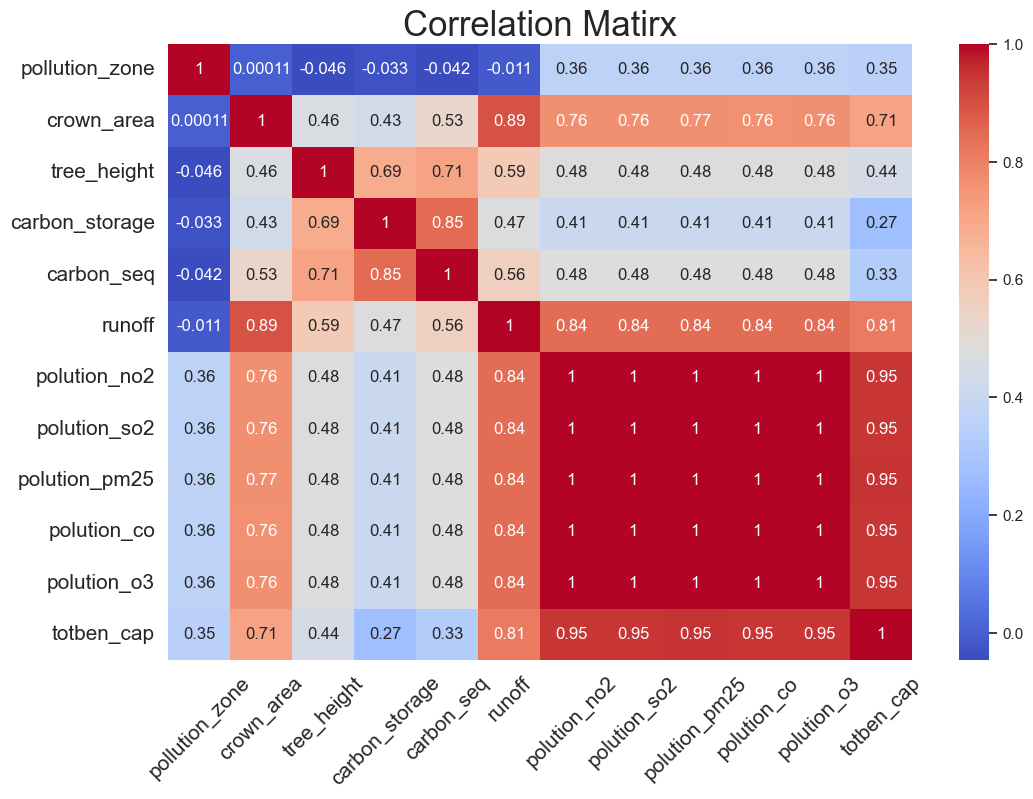

In [15]:
# drop columns with name 'id' and 'genus'
df_corr = df.drop(['tree_id', 'crown_id','dbh','dbh_in_situ','sp_in_situ','lon_x', 'lat_y'], axis=1)
correlation_matrix = df_corr.corr()

fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
ax.set_title("Correlation Matirx", fontweight='ultralight', fontsize=25)
plt.xticks(rotation=45,fontweight='ultralight', fontsize=15)
plt.yticks(fontsize=15)
plt.show()

- select columns to keep for modelling
- round values for pred and response var to 3 decimals (ensure that X,Y columns are not rounded!)

In [16]:
#print(df.columns)
col_id = ['tree_id']
col_coord = ['lon_x', 'lat_y']
predictors = ['tree_height', 'crown_area', 'pollution_zone', 'genus']
response_vars = ['carbon_storage', 'carbon_seq', 'runoff',
       'polution_no2', 'polution_so2', 'polution_pm25', 'polution_co',
       'polution_o3', 'totben_cap']



col_to_keep = col_id + predictors + response_vars + col_coord
print(col_to_keep)
df = df[col_to_keep]

# round response and predictor values to 2 decimals
df[predictors + response_vars] = df[predictors + response_vars].round(2)
display(df.head())


df_target = df_target[col_to_keep]
df_target[predictors + response_vars] = df_target[predictors + response_vars].round(2)
display(df_target)

['tree_id', 'tree_height', 'crown_area', 'pollution_zone', 'genus', 'carbon_storage', 'carbon_seq', 'runoff', 'polution_no2', 'polution_so2', 'polution_pm25', 'polution_co', 'polution_o3', 'totben_cap', 'lon_x', 'lat_y']


,tree_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,polution_so2,polution_pm25,polution_co,polution_o3,totben_cap,lon_x,lat_y
73,14640,6.35,7.64,1,Fraxinus,61.0,3.0,0.1,8.2,0.6,0.9,0.7,18.3,671.69,10.641744,59.961983
75,14644,15.86,168.88,1,Acer,372.8,15.1,3.7,234.5,17.3,24.5,21.2,525.4,15053.49,10.642142,59.962042
76,14645,18.94,126.77,1,Fraxinus,537.0,10.6,1.6,99.3,7.3,10.4,9.0,222.4,7341.20,10.642501,59.962011
78,14647,16.47,221.40,1,Fraxinus,324.8,12.9,2.1,132.5,9.8,13.8,12.0,296.9,9792.37,10.643127,59.962118
79,14648,12.26,124.75,1,Ulmus,174.4,9.5,1.5,96.5,7.1,10.1,8.7,216.1,6663.60,10.643412,59.962164


,tree_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,polution_so2,polution_pm25,polution_co,polution_o3,totben_cap,lon_x,lat_y
0,1,15.0,96.40,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,18.0,61.74,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,17.0,77.37,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6,16.0,185.62,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,17.0,161.59,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118010,137907,18.0,32.48,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118011,137908,21.0,68.97,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118012,137909,20.0,45.49,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118013,137910,28.0,49.52,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Import target dataset

TODO 
- export data from Bærum 
- Clean data from Bærum 
- Fill no data values with species distr. 
- predict values


In [17]:
# create a histogram for genus distribution
df_genus = df.groupby('genus').count()
df_genus = df_genus[['tree_id']]
df_genus.rename(columns={'tree_id': 'count'}, inplace=True)
df_genus.sort_values(by=['count'], inplace=True, ascending=False)
df_genus.reset_index(inplace=True)

# probability distribution of genus in percent
df_genus['probability'] = df_genus['count']/df_genus['count'].sum()
df_genus['prob_percentage'] = round(df_genus['probability']*100)
display(df_genus.head())

df_genus['probability'].sum()

,genus,count,probability,prob_percentage
0,Tilia,4152,0.259825,26.0
1,Acer,3242,0.202879,20.0
2,Betula,1909,0.119462,12.0
3,Ulmus,1249,0.078160,8.0
4,Prunus,1044,0.065332,7.0


0.9999999999999999

2023.05.26T18:59:16Z [DEBUG] matplotlib.font_manager: findfont: Matching sans\-serif:style=normal:variant=normal:weight=ultralight:stretch=normal:size=11.0.
2023.05.26T18:59:16Z [DEBUG] matplotlib.font_manager: findfont: score(FontEntry(fname='c:\\Users\\willeke.acampo\\Anaconda3\\envs\\urban-treeDetection\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
2023.05.26T18:59:16Z [DEBUG] matplotlib.font_manager: findfont: score(FontEntry(fname='c:\\Users\\willeke.acampo\\Anaconda3\\envs\\urban-treeDetection\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
2023.05.26T18:59:16Z [DEBUG] matplotlib.font_manager: findfont: score(FontEntry(fname='c:\\Users\\willeke.acampo\\Anaconda3\\envs\\urban-treeDetection\\lib\\site-packages\\mat

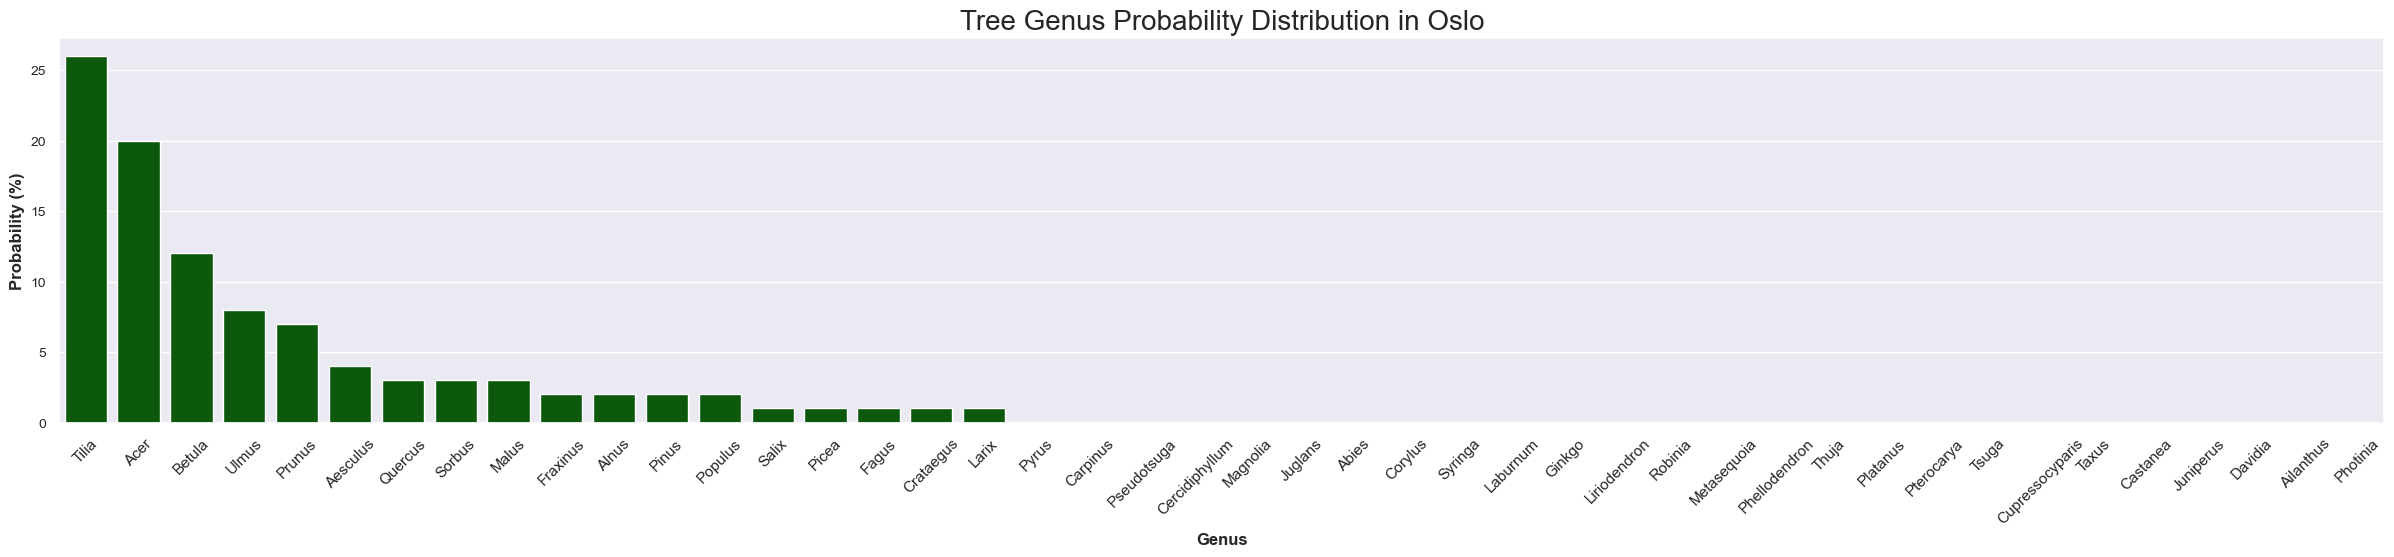

In [18]:
# plot histogram
fig, ax = plt.subplots(figsize=(30, 5))
sns.barplot(x='genus', y='prob_percentage', data=df_genus, ax=ax, color="darkgreen")
ax.set_title("Tree Genus Probability Distribution in Oslo", fontweight='ultralight', fontsize=20)
ax.set_xlabel("Genus", fontweight='bold')
ax.set_ylabel("Probability (%)", fontweight='bold')
plt.xticks(rotation=45,fontweight='ultralight') 
plt.yticks(fontsize=10)
plt.show()

In [19]:
# fil no data values in test_df['genus'] by using the probability distribution of df['genus']
df_target['genus'] = df_target['genus'].apply(lambda x: np.random.choice(df_genus['genus'], p=df_genus['probability']) if pd.isnull(x) else x)

# print the probability distribution of target_data['genus']
target_data_genus = df_target.groupby('genus').count()
target_data_genus = target_data_genus[['tree_id']]
target_data_genus.rename(columns={'tree_id': 'count'}, inplace=True)
target_data_genus.sort_values(by=['count'], inplace=True, ascending=False)
target_data_genus.reset_index(inplace=True)

,genus,count,probability,prob_percentage
0,Tilia,30688,0.260035,26.0
1,Acer,23811,0.201762,20.0
2,Betula,14117,0.119620,12.0
3,Ulmus,9192,0.077888,8.0
4,Prunus,7886,0.066822,7.0


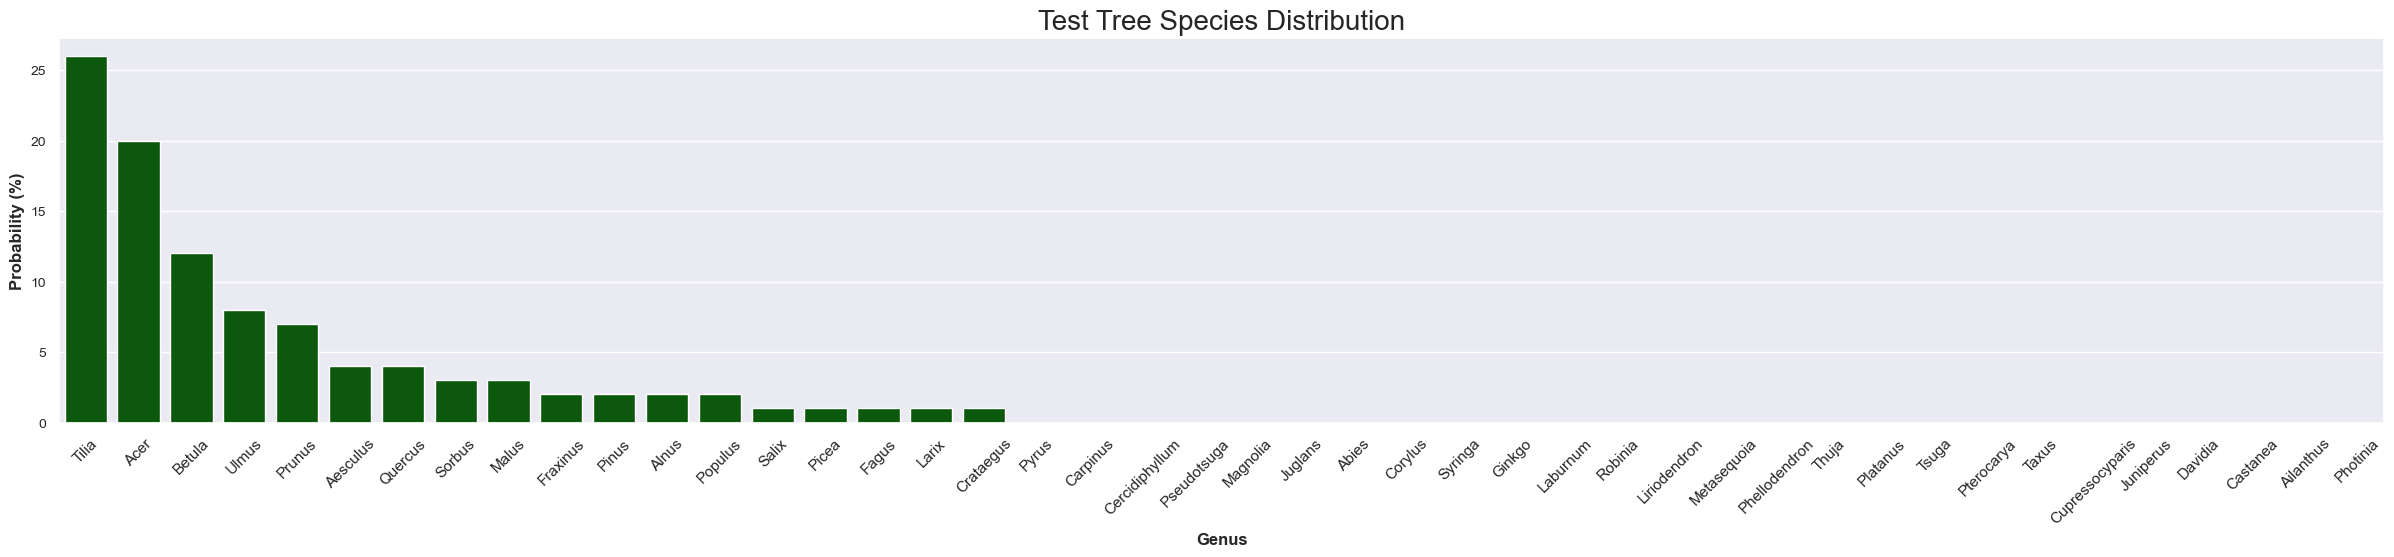

In [20]:
# probability distribution of genus in percent
target_data_genus['probability'] = target_data_genus['count']/target_data_genus['count'].sum()
target_data_genus['prob_percentage'] = round(target_data_genus['probability']*100)
display(target_data_genus.head())

# plot histogram
fig, ax = plt.subplots(figsize=(30, 5))
sns.barplot(x='genus', y='prob_percentage', data=target_data_genus, ax=ax, color="darkgreen")
ax.set_title("Test Tree Species Distribution", fontweight='ultralight', fontsize=20)
ax.set_xlabel("Genus", fontweight='bold')
ax.set_ylabel("Probability (%)", fontweight='bold')
plt.xticks(rotation=45,fontweight='ultralight')
plt.yticks(fontsize=10)
plt.show()

In [21]:
display(df_target.head())

,tree_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,polution_so2,polution_pm25,polution_co,polution_o3,totben_cap,lon_x,lat_y
0,1,15.0,96.40,1,Prunus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,18.0,61.74,1,Acer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,17.0,77.37,1,Ulmus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6,16.0,185.62,1,Acer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,17.0,161.59,1,Tilia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Non-weighted Regression without genus

y = b0 + b1x1 + b2x2 + b3*x3 + ...

where:

y is the dependent variable,
x1, x2, x3, ... are the independent variables,
b0 is the y-intercept of the regression line, and
b1, b2, b3, ... are the coefficients for each independent variable.

non-weighted regression

In [22]:
df.columns

Index(['tree_id', 'tree_height', 'crown_area', 'pollution_zone', 'genus',
       'carbon_storage', 'carbon_seq', 'runoff', 'polution_no2',
       'polution_so2', 'polution_pm25', 'polution_co', 'polution_o3',
       'totben_cap', 'lon_x', 'lat_y'],
      dtype='object')

In [23]:
# Extract the features (X) and the target variable (y) from the DataFrame

predictors = ['tree_height', 'crown_area', 'pollution_zone']
response_vars = ['carbon_storage', 'carbon_seq', 'runoff',
       'polution_no2', 'polution_so2', 'polution_pm25', 'polution_co',
       'polution_o3', 'totben_cap']

for var in response_vars:
    y = df[var]

2023.05.26T18:59:20Z [DEBUG] matplotlib.font_manager: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=8.0.
2023.05.26T18:59:20Z [DEBUG] matplotlib.font_manager: findfont: score(FontEntry(fname='c:\\Users\\willeke.acampo\\Anaconda3\\envs\\urban-treeDetection\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023.05.26T18:59:20Z [DEBUG] matplotlib.font_manager: findfont: score(FontEntry(fname='c:\\Users\\willeke.acampo\\Anaconda3\\envs\\urban-treeDetection\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023.05.26T18:59:20Z [DEBUG] matplotlib.font_manager: findfont: score(FontEntry(fname='c:\\Users\\willeke.acampo\\Anaconda3\\envs\\urban-treeDetection\\lib\\site-packages\\matplotlib

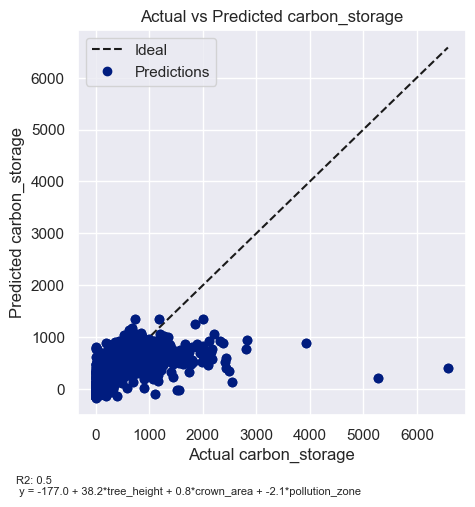

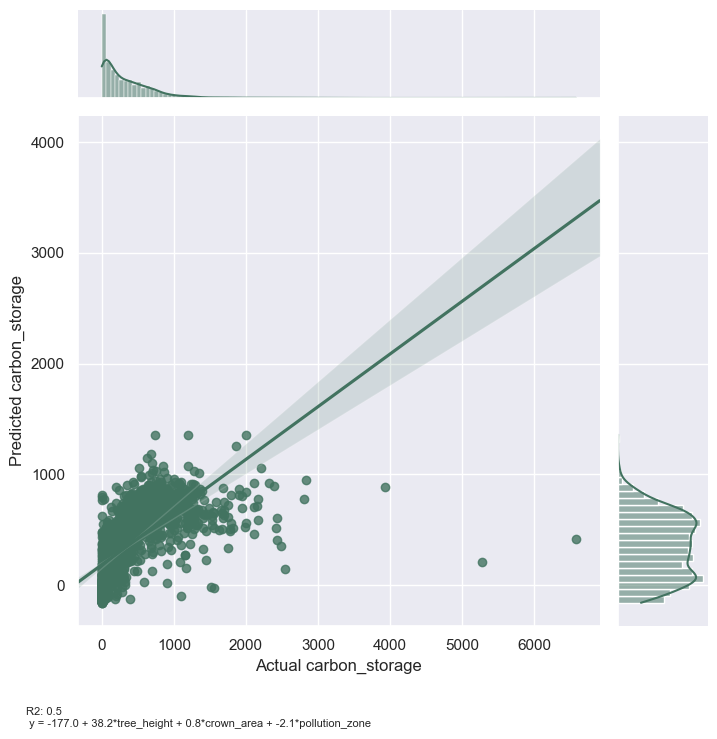

In [24]:
X = df[predictors]
seed = 42
test_size = 0.2

dict_results = {}

# TODO store model in dictionairy {model_name:model}
# TODO store model results in dataframe df_results dict. {model_name:df_results}

# loop over response variables and calc. linear regression 
for var in response_vars:
       y = df[var]
       #display(X.head())
       #display(y.head())

       # Split the data into training and testing sets
       X_train, X_test, y_train, y_test = train_test_split(
              X, 
              y, 
              test_size=test_size, 
              random_state=seed
              )

       # Create and fit the regression model
       model = LinearRegression()
       model.fit(X_train, y_train)
       
       b0 = round(model.intercept_, 1)
       b1 = round(model.coef_[0], 1)
       b2 = round(model.coef_[1], 1)
       b3 = round(model.coef_[2], 1)
       y = var
       x1 = predictors[0]
       x2 = predictors[1]
       x3 = predictors[2]
       model_equation = f'y = {b0} + {b1}*{x1} + {b2}*{x2} + {b3}*{x3}' 
       
       #model_equation = f'y = {model.intercept_} + {model.coef_[0]}*x1 + \
        #      {model.coef_[1]}*x2 + {model.coef_[2]}*x3'

       # Make predictions on the training and testing sets
       y_train_pred = model.predict(X_train)
       y_test_pred = model.predict(X_test)

       # store model results in dataframe df_results
       #r2 train round to 2

       r2_train = round(r2_score(y_train, y_train_pred),2)
       r2_test = round(r2_score(y_test, y_test_pred),2)
       r2_train = round(r2_train, 2)
       df_results = pd.DataFrame(columns=['model_name', 'response_var', 'equation', 'train_rmse', 'test_rmse', 'train_r2', 'test_r2'])
       df_results['model_name'] = f'model_{var}'
       df_results['response_var'] = var
       df_results['equation'] = model_equation
       df_results['train_rmse'] = np.sqrt(mean_squared_error(y_train, y_train_pred))
       df_results['test_rmse'] = np.sqrt(mean_squared_error(y_test, y_test_pred))
       df_results['train_r2'] = r2_train
       df_results['test_r2'] = r2_test
       
       # append results dataframe to dict
       dict_results[f'model_{var}'] = df_results
       
       # plot results and save plot to output folder
       fig1, ax1 = plt.subplots(figsize=(5, 5))
       # Add the regression line of best fit
       plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k', label='Ideal')
       plt.plot(y_test, y_test_pred, 'bo', label='Predictions')
       plt.legend()
       plt.scatter(y_test, y_test_pred)
       plt.xlabel(f"Actual {var}")
       plt.ylabel(f"Predicted {var}")     
       plt.title(f"Actual vs Predicted {var}")
       # # print R2 and model equation under the plot
       # Add text under the figure in italic
       plt.figtext(0, -0.05, f"R2: {r2_train}\n {model_equation}", ha='left', fontsize=8)

       #plt.text(f"R2: {df_results['test_r2'][0]:.2f}", fontsize=12)
       # plt.text(f"Equation: {model_equation}", fontsize=12)
       
       # # save plot to output folder
       # output_path = os.path.join(INTERIM_PATH, f'linear_reg_{var}.png')
       # #plt.savefig(output_path, dpi=300, bbox_inches='tight')
       
       # FIGURE 2       
       sns.jointplot(x=y_test, y=y_test_pred,
                  kind="reg", truncate=False,
                  #xlim=(0, 60), ylim=(0, 12),
                  color="#427360", height=7)
       plt.xlabel(f"Actual {var}")
       plt.ylabel(f"Predicted {var}")     
       # # print R2 and model equation under the plot
       # Add text under the figure in italic
       plt.figtext(0, -0.05, f"R2: {r2_train}\n {model_equation}", ha='left', fontsize=8)
       plt.show()
       break



## WITH GENUS ENCODED INFO

In [25]:
# One-hot encoding for species
df['genus'] = df['genus'].astype('category')

# encode genus for regression
genus_encoded = pd.get_dummies(df['genus'], prefix='genus')

# get genus encoded column names
genus_encoded_cols = list(genus_encoded.columns)
# replace genus_ wiht "" in column names 
genus_encoded_cols = [x.replace('genus_', '') for x in genus_encoded_cols]
genus_encoded_cols = [x.lower() for x in genus_encoded_cols]

# replace col names with formatted col names
genus_encoded.columns = genus_encoded_cols

df = pd.concat([df, genus_encoded], axis=1)
print(genus_encoded_cols)

['abies', 'acer', 'aesculus', 'ailanthus', 'alnus', 'betula', 'carpinus', 'castanea', 'cercidiphyllum', 'corylus', 'crataegus', 'cupressocyparis', 'davidia', 'fagus', 'fraxinus', 'ginkgo', 'juglans', 'juniperus', 'laburnum', 'larix', 'liriodendron', 'magnolia', 'malus', 'metasequoia', 'phellodendron', 'photinia', 'picea', 'pinus', 'platanus', 'populus', 'prunus', 'pseudotsuga', 'pterocarya', 'pyrus', 'quercus', 'robinia', 'salix', 'sorbus', 'syringa', 'taxus', 'thuja', 'tilia', 'tsuga', 'ulmus']


In [26]:
target_genus_encoded = pd.get_dummies(df_target['genus'])
target_genus_encoded_cols = list(target_genus_encoded.columns)
target_genus_encoded_cols = [x.lower() for x in target_genus_encoded_cols]

# replace col names with formatted col names
target_genus_encoded.columns = target_genus_encoded_cols

df_target = pd.concat([df_target, target_genus_encoded],axis=1)
display(df_target.head())




,tree_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,polution_so2,...,quercus,robinia,salix,sorbus,syringa,taxus,thuja,tilia,tsuga,ulmus
0,1,15.0,96.40,1,Prunus,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2,18.0,61.74,1,Acer,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,4,17.0,77.37,1,Ulmus,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
3,6,16.0,185.62,1,Acer,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,8,17.0,161.59,1,Tilia,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# drop lon lat column from df target
drop_cols = ['lat_y','lon_x']
df.drop(drop_cols, axis=1, inplace=True)
df_target.drop(drop_cols, axis=1, inplace=True)

In [37]:
# ensure that df and df_target contain the same column names 
same_columns = df.columns.equals(df_target.columns)
print(same_columns)
print(df.columns)
print(df_target.columns)

True
Index(['tree_id', 'tree_height', 'crown_area', 'pollution_zone', 'genus',
       'carbon_storage', 'carbon_seq', 'runoff', 'polution_no2',
       'polution_so2', 'polution_pm25', 'polution_co', 'polution_o3',
       'totben_cap', 'abies', 'acer', 'aesculus', 'ailanthus', 'alnus',
       'betula', 'carpinus', 'castanea', 'cercidiphyllum', 'corylus',
       'crataegus', 'cupressocyparis', 'davidia', 'fagus', 'fraxinus',
       'ginkgo', 'juglans', 'juniperus', 'laburnum', 'larix', 'liriodendron',
       'magnolia', 'malus', 'metasequoia', 'phellodendron', 'photinia',
       'picea', 'pinus', 'platanus', 'populus', 'prunus', 'pseudotsuga',
       'pterocarya', 'pyrus', 'quercus', 'robinia', 'salix', 'sorbus',
       'syringa', 'taxus', 'thuja', 'tilia', 'tsuga', 'ulmus'],
      dtype='object')
Index(['tree_id', 'tree_height', 'crown_area', 'pollution_zone', 'genus',
       'carbon_storage', 'carbon_seq', 'runoff', 'polution_no2',
       'polution_so2', 'polution_pm25', 'polution_co',

In [38]:
# Extract the features (X) and the target variable (y) from the DataFrame

predictors = ['tree_height', 'crown_area', 'pollution_zone'] + genus_encoded_cols
response_vars = ['carbon_storage', 'carbon_seq', 'runoff',
       'polution_no2', 'polution_so2', 'polution_pm25', 'polution_co',
       'polution_o3', 'totben_cap']

for var in response_vars:
    y = df[var]

Model: carbon_storage
Equation: y = -214.7 + 37.7*tree_height + 0.6*crown_area + 6.0*pollution_zone + -51.5*abies + ...


,tree_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,polution_so2,...,quercus,robinia,salix,sorbus,syringa,taxus,thuja,tilia,tsuga,ulmus
0,1,15.0,96.40,1,Prunus,450.720360,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2,18.0,61.74,1,Acer,578.752069,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,4,17.0,77.37,1,Ulmus,682.888896,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
3,6,16.0,185.62,1,Acer,578.992765,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,8,17.0,161.59,1,Tilia,490.867440,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0


<Figure size 640x480 with 0 Axes>

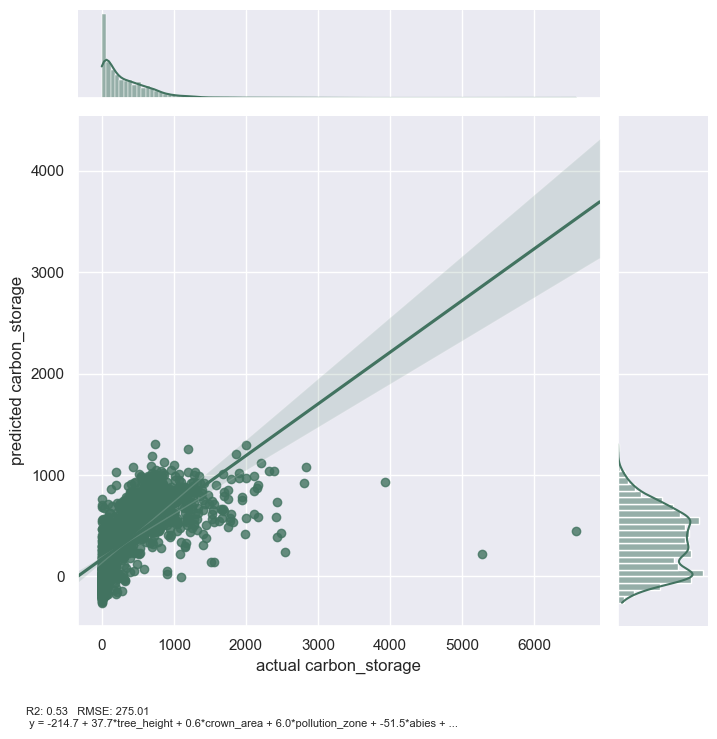

Model: carbon_seq
Equation: y = -1.1 + 0.5*tree_height + 0.0*crown_area + 0.0*pollution_zone + -1.6*abies + ...


,tree_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,polution_so2,...,quercus,robinia,salix,sorbus,syringa,taxus,thuja,tilia,tsuga,ulmus
0,1,15.0,96.40,1,Prunus,450.720360,10.657215,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2,18.0,61.74,1,Acer,578.752069,11.221511,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,4,17.0,77.37,1,Ulmus,682.888896,11.578785,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
3,6,16.0,185.62,1,Acer,578.992765,12.536760,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,8,17.0,161.59,1,Tilia,490.867440,10.418676,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0


<Figure size 640x480 with 0 Axes>

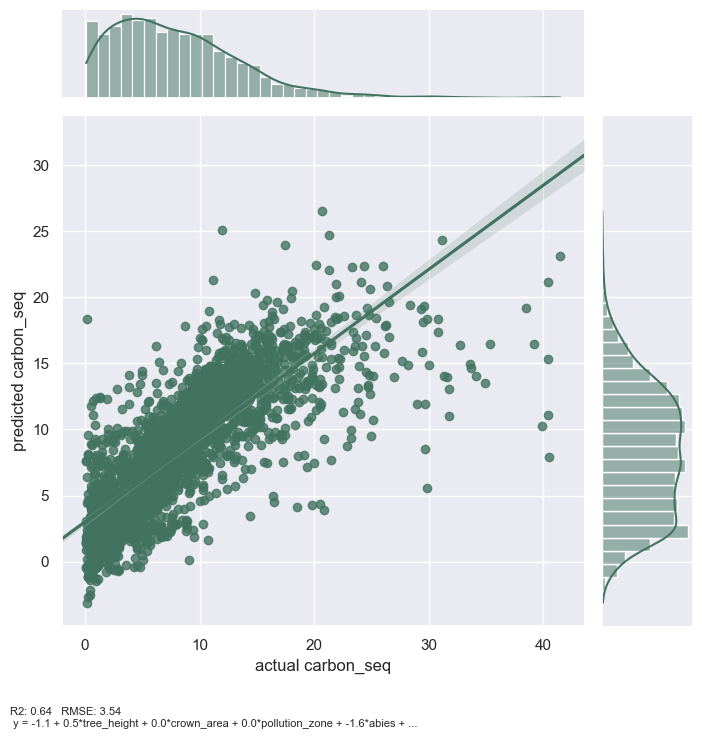

Model: runoff
Equation: y = -0.2 + 0.0*tree_height + 0.0*crown_area + -0.0*pollution_zone + 0.2*abies + ...


,tree_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,polution_so2,...,quercus,robinia,salix,sorbus,syringa,taxus,thuja,tilia,tsuga,ulmus
0,1,15.0,96.40,1,Prunus,450.720360,10.657215,1.617140,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2,18.0,61.74,1,Acer,578.752069,11.221511,1.468743,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,4,17.0,77.37,1,Ulmus,682.888896,11.578785,1.364779,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
3,6,16.0,185.62,1,Acer,578.992765,12.536760,3.087556,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,8,17.0,161.59,1,Tilia,490.867440,10.418676,2.801725,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0


<Figure size 640x480 with 0 Axes>

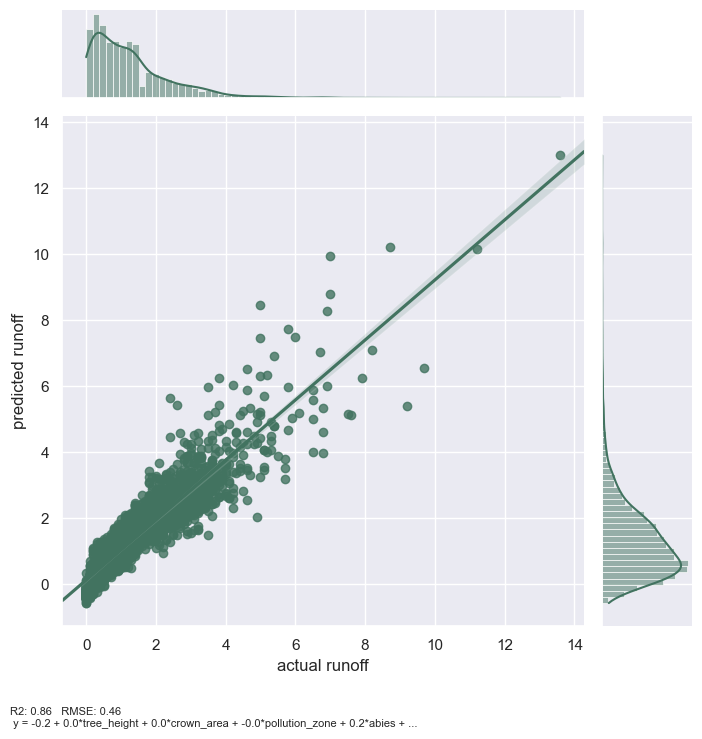

Model: polution_no2
Equation: y = -330.5 + 7.2*tree_height + 2.4*crown_area + 168.1*pollution_zone + 14.8*abies + ...


,tree_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,polution_so2,...,quercus,robinia,salix,sorbus,syringa,taxus,thuja,tilia,tsuga,ulmus
0,1,15.0,96.40,1,Prunus,450.720360,10.657215,1.617140,162.333687,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2,18.0,61.74,1,Acer,578.752069,11.221511,1.468743,128.597155,NaN,...,0,0,0,0,0,0,0,0,0,0
2,4,17.0,77.37,1,Ulmus,682.888896,11.578785,1.364779,112.951002,NaN,...,0,0,0,0,0,0,0,0,0,1
3,6,16.0,185.62,1,Acer,578.992765,12.536760,3.087556,414.526010,NaN,...,0,0,0,0,0,0,0,0,0,0
4,8,17.0,161.59,1,Tilia,490.867440,10.418676,2.801725,361.476745,NaN,...,0,0,0,0,0,0,0,1,0,0


<Figure size 640x480 with 0 Axes>

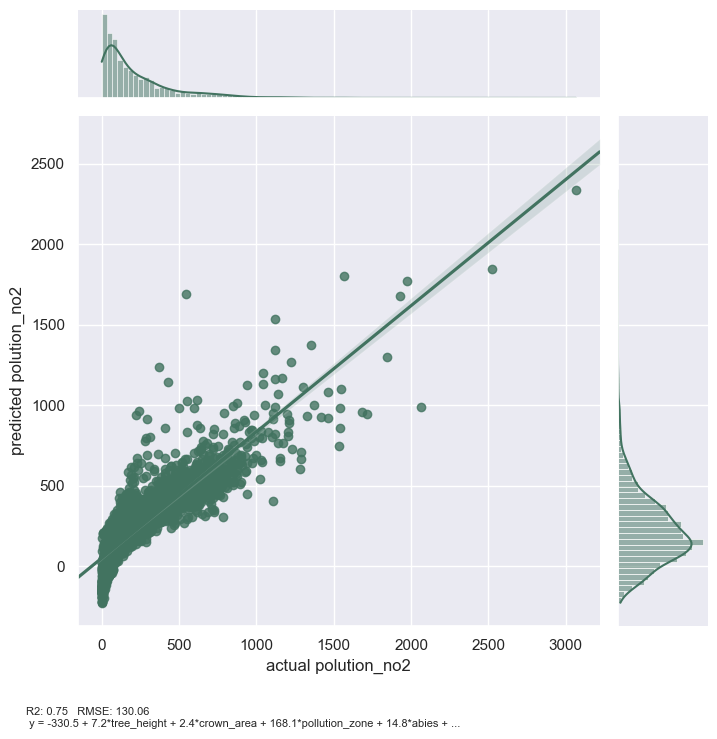

Model: polution_so2
Equation: y = -24.4 + 0.5*tree_height + 0.2*crown_area + 12.4*pollution_zone + 1.1*abies + ...


,tree_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,polution_so2,...,quercus,robinia,salix,sorbus,syringa,taxus,thuja,tilia,tsuga,ulmus
0,1,15.0,96.40,1,Prunus,450.720360,10.657215,1.617140,162.333687,12.007292,...,0,0,0,0,0,0,0,0,0,0
1,2,18.0,61.74,1,Acer,578.752069,11.221511,1.468743,128.597155,9.511914,...,0,0,0,0,0,0,0,0,0,0
2,4,17.0,77.37,1,Ulmus,682.888896,11.578785,1.364779,112.951002,8.356699,...,0,0,0,0,0,0,0,0,0,1
3,6,16.0,185.62,1,Acer,578.992765,12.536760,3.087556,414.526010,30.634474,...,0,0,0,0,0,0,0,0,0,0
4,8,17.0,161.59,1,Tilia,490.867440,10.418676,2.801725,361.476745,26.707066,...,0,0,0,0,0,0,0,1,0,0


<Figure size 640x480 with 0 Axes>

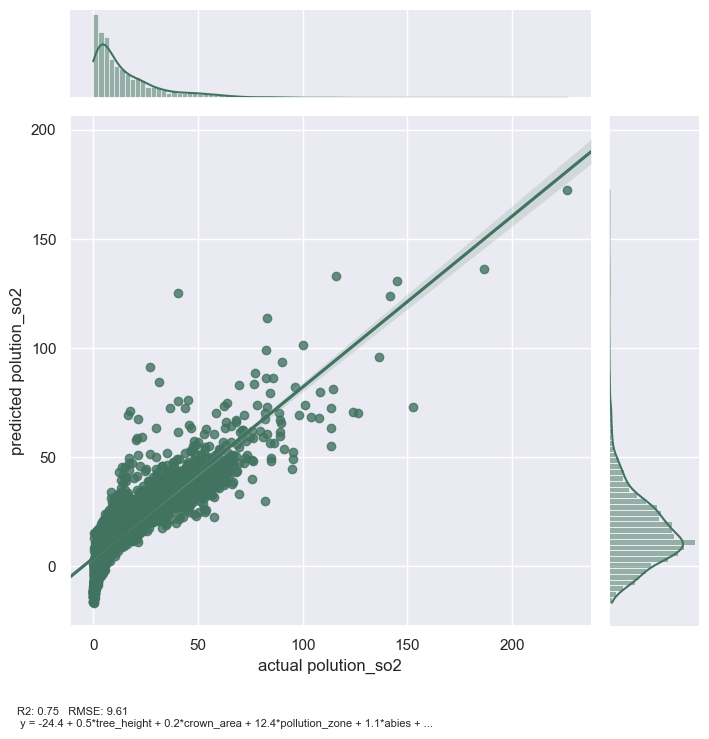

Model: polution_pm25
Equation: y = -33.7 + 0.7*tree_height + 0.2*crown_area + 17.2*pollution_zone + 1.7*abies + ...


,tree_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,polution_so2,...,quercus,robinia,salix,sorbus,syringa,taxus,thuja,tilia,tsuga,ulmus
0,1,15.0,96.40,1,Prunus,450.720360,10.657215,1.617140,162.333687,12.007292,...,0,0,0,0,0,0,0,0,0,0
1,2,18.0,61.74,1,Acer,578.752069,11.221511,1.468743,128.597155,9.511914,...,0,0,0,0,0,0,0,0,0,0
2,4,17.0,77.37,1,Ulmus,682.888896,11.578785,1.364779,112.951002,8.356699,...,0,0,0,0,0,0,0,0,0,1
3,6,16.0,185.62,1,Acer,578.992765,12.536760,3.087556,414.526010,30.634474,...,0,0,0,0,0,0,0,0,0,0
4,8,17.0,161.59,1,Tilia,490.867440,10.418676,2.801725,361.476745,26.707066,...,0,0,0,0,0,0,0,1,0,0


<Figure size 640x480 with 0 Axes>

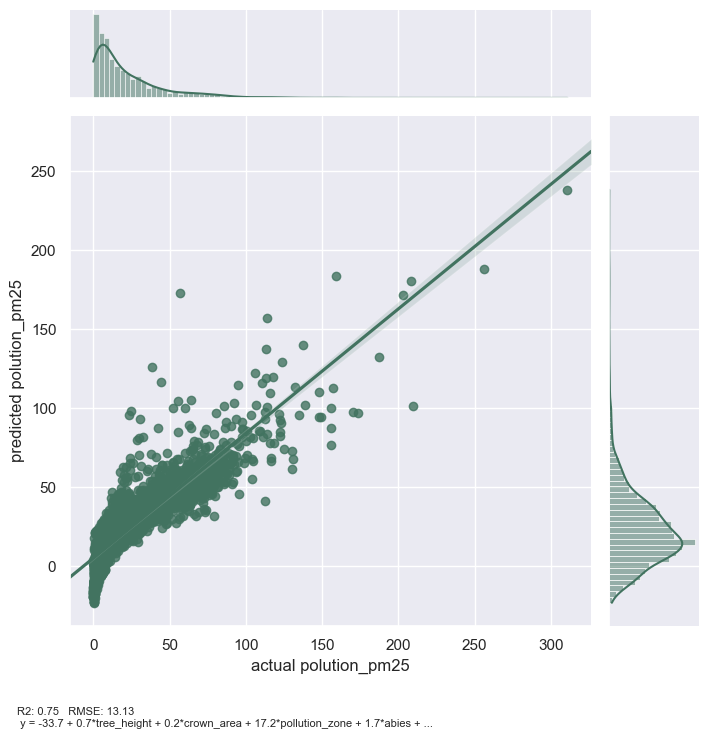

Model: polution_co
Equation: y = -30.6 + 0.7*tree_height + 0.2*crown_area + 15.6*pollution_zone + 1.3*abies + ...


,tree_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,polution_so2,...,quercus,robinia,salix,sorbus,syringa,taxus,thuja,tilia,tsuga,ulmus
0,1,15.0,96.40,1,Prunus,450.720360,10.657215,1.617140,162.333687,12.007292,...,0,0,0,0,0,0,0,0,0,0
1,2,18.0,61.74,1,Acer,578.752069,11.221511,1.468743,128.597155,9.511914,...,0,0,0,0,0,0,0,0,0,0
2,4,17.0,77.37,1,Ulmus,682.888896,11.578785,1.364779,112.951002,8.356699,...,0,0,0,0,0,0,0,0,0,1
3,6,16.0,185.62,1,Acer,578.992765,12.536760,3.087556,414.526010,30.634474,...,0,0,0,0,0,0,0,0,0,0
4,8,17.0,161.59,1,Tilia,490.867440,10.418676,2.801725,361.476745,26.707066,...,0,0,0,0,0,0,0,1,0,0


<Figure size 640x480 with 0 Axes>

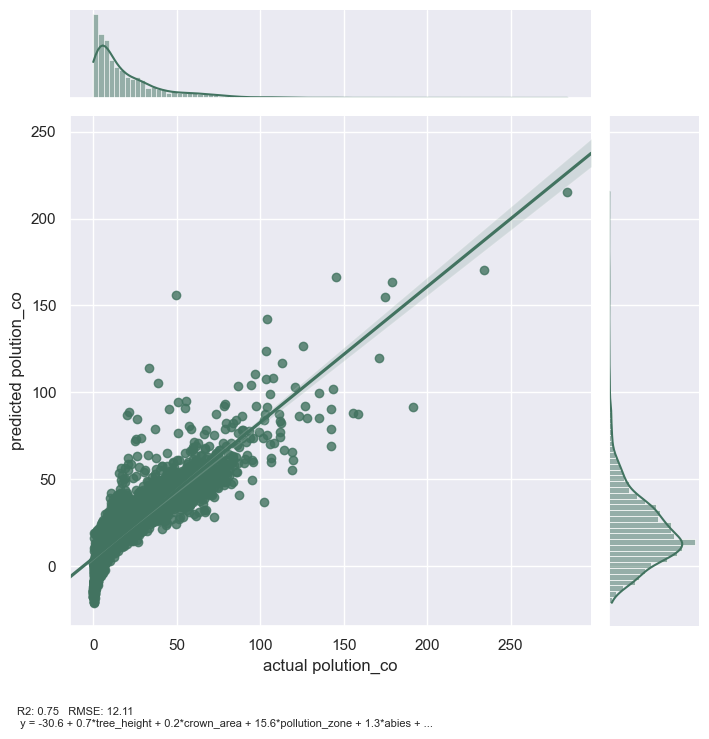

Model: polution_o3
Equation: y = -747.6 + 16.2*tree_height + 5.5*crown_area + 380.4*pollution_zone + 33.2*abies + ...


,tree_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,polution_so2,...,quercus,robinia,salix,sorbus,syringa,taxus,thuja,tilia,tsuga,ulmus
0,1,15.0,96.40,1,Prunus,450.720360,10.657215,1.617140,162.333687,12.007292,...,0,0,0,0,0,0,0,0,0,0
1,2,18.0,61.74,1,Acer,578.752069,11.221511,1.468743,128.597155,9.511914,...,0,0,0,0,0,0,0,0,0,0
2,4,17.0,77.37,1,Ulmus,682.888896,11.578785,1.364779,112.951002,8.356699,...,0,0,0,0,0,0,0,0,0,1
3,6,16.0,185.62,1,Acer,578.992765,12.536760,3.087556,414.526010,30.634474,...,0,0,0,0,0,0,0,0,0,0
4,8,17.0,161.59,1,Tilia,490.867440,10.418676,2.801725,361.476745,26.707066,...,0,0,0,0,0,0,0,1,0,0


<Figure size 640x480 with 0 Axes>

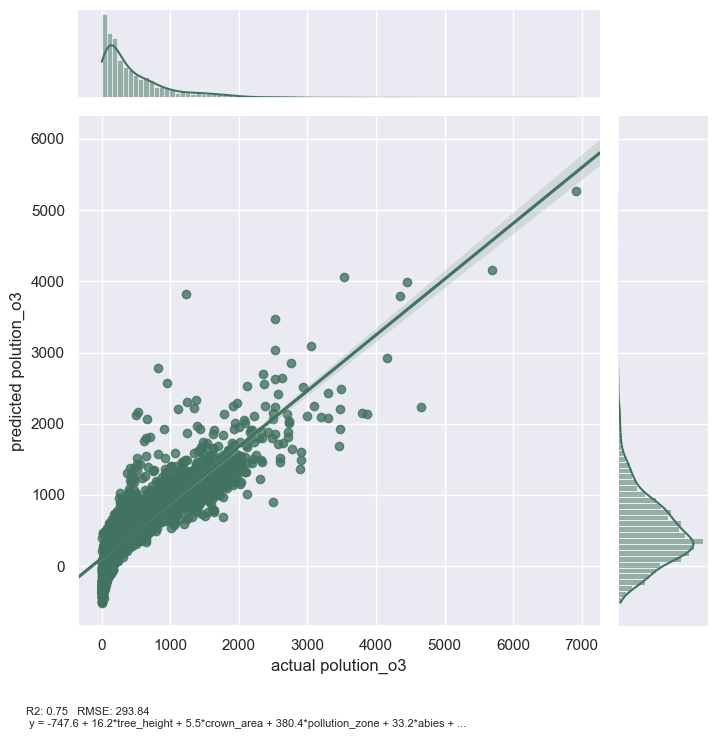

Model: totben_cap
Equation: y = -15422.8 + 328.5*tree_height + 124.1*crown_area + 8576.8*pollution_zone + 312.7*abies + ...


,tree_id,tree_height,crown_area,pollution_zone,genus,carbon_storage,carbon_seq,runoff,polution_no2,polution_so2,...,quercus,robinia,salix,sorbus,syringa,taxus,thuja,tilia,tsuga,ulmus
0,1,15.0,96.40,1,Prunus,450.720360,10.657215,1.617140,162.333687,12.007292,...,0,0,0,0,0,0,0,0,0,0
1,2,18.0,61.74,1,Acer,578.752069,11.221511,1.468743,128.597155,9.511914,...,0,0,0,0,0,0,0,0,0,0
2,4,17.0,77.37,1,Ulmus,682.888896,11.578785,1.364779,112.951002,8.356699,...,0,0,0,0,0,0,0,0,0,1
3,6,16.0,185.62,1,Acer,578.992765,12.536760,3.087556,414.526010,30.634474,...,0,0,0,0,0,0,0,0,0,0
4,8,17.0,161.59,1,Tilia,490.867440,10.418676,2.801725,361.476745,26.707066,...,0,0,0,0,0,0,0,1,0,0


<Figure size 640x480 with 0 Axes>

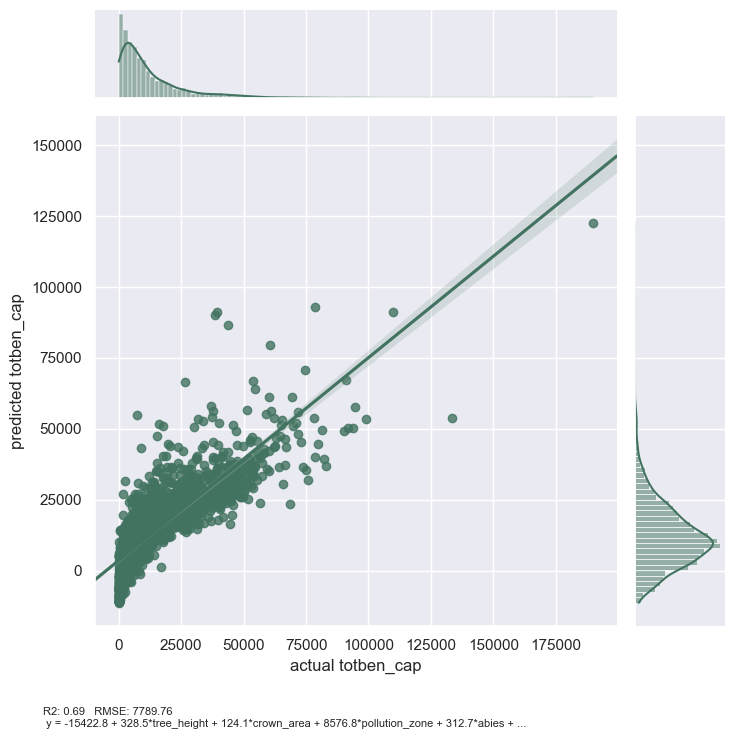

<Figure size 640x480 with 0 Axes>

In [40]:
X = df[predictors]
X_target = df_target[predictors]
seed = 42
test_size = 0.2

dict_results = {}

# TODO store model in dictionairy {model_name:model}
# TODO store model results in dataframe df_results dict. {model_name:df_results}

# loop over response variables and calc. linear regression 
for var in response_vars:
       y = df[var]
       #display(X.head())
       #display(y.head())

       # Split the data into training and testing sets
       X_train, X_test, y_train, y_test = train_test_split(
              X, 
              y, 
              test_size=test_size, 
              random_state=seed
              )

       # Create and fit the regression model
       model = LinearRegression()
       model.fit(X_train, y_train)
       
       b0 = round(model.intercept_, 1)
       b1 = round(model.coef_[0], 1)
       b2 = round(model.coef_[1], 1)
       b3 = round(model.coef_[2], 1)
       b4 = round(model.coef_[3], 1)
       y = var
       x1 = predictors[0]
       x2 = predictors[1]
       x3 = predictors[2]
       x4 = predictors[3]

       model_equation = f'y = {b0} + {b1}*{x1} + {b2}*{x2} + {b3}*{x3} + {b4}*{x4} + ...' 
       
       #model_equation = f'y = {model.intercept_} + {model.coef_[0]}*x1 + \
        #      {model.coef_[1]}*x2 + {model.coef_[2]}*x3'

       # Make predictions on the training and testing sets
       y_train_pred = model.predict(X_train)
       y_test_pred = model.predict(X_test)

       # store model results in dataframe df_results
       #r2 train round to 2

       r2_train = round(r2_score(y_train, y_train_pred),2)
       r2_test = round(r2_score(y_test, y_test_pred),2)
       r2_train = round(r2_train, 2)
       rmse_train = round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)
       
       df_results = pd.DataFrame(columns=['model_name', 'response_var', 'equation', 'train_rmse', 'test_rmse', 'train_r2', 'test_r2'])
       df_results['model_name'] = f'model_{var}'
       df_results['response_var'] = var
       df_results['equation'] = model_equation
       df_results['train_rmse'] = rmse_train
       df_results['test_rmse'] = np.sqrt(mean_squared_error(y_test, y_test_pred))
       df_results['train_r2'] = r2_train
       df_results['test_r2'] = r2_test
       
       # append results dataframe to dict
       dict_results[f'model_{var}'] = df_results
       
       
       # Apply the regression model to the df_target dataset
       y_target_pred = model.predict(X_target)

       # Fill the response columns in df_target with the predicted values
       df_target[var] = y_target_pred
       # 
       # deploy model on target data
       #df_target[var] = model.predict(df_target)
       
       # print results
       print(f"Model: {var}")
       print(f"Equation: {model_equation}")
       display(df_target.head())

       
       # # plot results and save plot to output folder
       # fig1, ax1 = plt.subplots(figsize=(5, 5))
       # # Add the regression line of best fit
       # plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k', label='Ideal')
       # plt.plot(y_test, y_test_pred, 'bo', label='Predictions')
       # plt.legend()
       # plt.scatter(y_test, y_test_pred)
       # plt.xlabel(f"Actual {var}")
       # plt.ylabel(f"Predicted {var}")     
       # plt.title(f"Actual vs Predicted {var}")
       # # # print R2 and model equation under the plot
       # # Add text under the figure in italic
       # plt.figtext(0, -0.05, f"R2: {r2_train}\n {model_equation}", ha='left', fontsize=8)

       #plt.text(f"R2: {df_results['test_r2'][0]:.2f}", fontsize=12)
       # plt.text(f"Equation: {model_equation}", fontsize=12)
       

       
       # FIGURE 2
       plt.clf()
       
       sns.jointplot(x=y_test, y=y_test_pred,
                  kind="reg", truncate=False,
                  #xlim=(0, 60), ylim=(0, 12),
                  color="#427360", height=7)
       plt.xlabel(f"actual {var}")
       plt.ylabel(f"predicted {var}")     
       # # print R2 and model equation under the plot
       # Add text under the figure in italic
       plt.figtext(0, -0.05, f"R2: {r2_train}   RMSE: {rmse_train}\n {model_equation}", ha='left', fontsize=8)
       plt.show()
       
       # save plot to output folder
       output_path = os.path.join(INTERIM_PATH, f'linear_reg_{var}.png')
       plt.savefig(output_path, dpi=300, bbox_inches='tight')



In [48]:
# export the results in df_target
df_target[predictors + response_vars]= round(df_target[predictors + response_vars],3)
csv_path = os.path.join(INTERIM_PATH, "baerum_extrapolation_results.csv")
df_target.to_csv(csv_path, index=False, sep= ";")


PermissionError: [Errno 13] Permission denied: 'C:\\Data\\offline_data\\trekroner\\data\\oslo\\interim\\baerum_extrapolation_results.csv'

# DEPLOY MODEL

# BACKUP

In [ ]:
# Extract the features (X) and the target variable (y) from the DataFrame
X = df[['tree_height', 'crown_area', 'pollution_zone']]
y = df['runoff']

display(X.head())
display(y.head())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the regression model
model = LinearRegression()
model.fit(X_train, y_train)


# Make predictions on the training and testing sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Train R^2: {train_r2:.2f}")

# Create the scatter plot using seabron 
fig, ax = plt.subplots(figsize=(5, 5))
# Add the regression line of best fit
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k', label='Ideal')
plt.plot(y_test, y_test_pred, 'bo', label='Predictions')
plt.legend()

plt.scatter(y_test, y_test_pred)
plt.xlabel("Actual carbon storage")
plt.ylabel("Predicted carbon storage")
plt.title("Actual vs Predicted carbon storage")
plt.text(4000, 6000, f"R2: {test_r2:.2f}", fontsize=12)

# Display the plot
plt.show()

In [ ]:
def sinplot(n=10, flip=1):
    x = np.linspace(0, 14, 100)
    for i in range(1, n + 1):
        plt.plot(x, np.sin(x + i * .5) * (n + 2 - i) * flip)
        
f = plt.figure(figsize=(6, 6))
gs = f.add_gridspec(2, 2)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 0])
    sinplot(6)

with sns.axes_style("white"):
    ax = f.add_subplot(gs[0, 1])
    sinplot(6)

with sns.axes_style("ticks"):
    ax = f.add_subplot(gs[1, 0])
    sinplot(6)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[1, 1])
    sinplot(6)

f.tight_layout()